<a href="https://colab.research.google.com/github/synsense/snn-workshop-amld-2022/blob/master/4.%20Auditory%20Processing/SNN_with_temporal_memory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 4 : Training a Spiking Neural Networks for a temporal memory task

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**: Hannah Bos, Philipp Weidel

**Estimated timing**: ...

Task: Create an SNN that classifies a stimulus depending on the context 
stimulus shown in the past. 


*   Use one hidden layer that stores a trace of the context stimulus in the synaptic time constants of the neurons.

<br/><br/>

![](https://raw.githubusercontent.com/synsense/snn-workshop-amld-2022/master/4.%20Auditory%20Processing/diagrams/setup.jpg)

## Setup

In [ ]:
!pip install samna
!pip install xylosim
!pip install git+https://gitlab.com/synsense/rockpool.git
!pip install tonic
!pip install torch
!pip install torchmetrics

## The data set

In [ ]:
#@title dataloader
%%writefile delay_task_dataloader.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

# create data set
import numpy as np
from torch.utils.data import DataLoader


class DelayTask:
    '''
        Channel A (chA) and channel (chB) represent two time-dependent values.
        This class defines a rate profile for each stimulus class and generates
        size_dataset samples by drawing random number of spikes per time step 
        from the rate profile.
        Channel A either generates a pulse at tA = offset_start remains silent.
        Channel B always generates a pulse start at tB = tA + delay.

        The two output neurons represent the classes
        A     + B -> class 0
        not A + B -> class 1

        :param pulse_width: pulse-width in number of time steps
        :param signal_strength: mean and std of pulse in spikes per time steps
                               [[meanA, meanB], [stdA, stdB]] 
        :param noise_strength: mean and std of noise in spikes per time steps
                               [mean, std]
        :param delay: number of time steps between start of pulse A and 
                      start of pulse B
        :param offset_start: time steps added before beginning of pulse A
        :param offset_stop: time steps added after end of pulse B
        :param max_spikes_per_dt: maximal number of spikes oer time step, 
                                  the signal is clipped to that values
        : param size_dataset: total number of samples
        :return:
      '''
    def __init__(self, pulse_width=10, signal_strength=[[7.0, 7.0], [1.0, 1.0]], 
                 noise_strength=[1.0, 1.0], delay=20, offset_start=10, 
                 offset_stop=10, max_spikes_per_dt=15, size_dataset=1000):

        self.mean_values, self.std_values = signal_strength
        self.mean_noise, self.std_noise = noise_strength
        self.max_spikes_per_dt = max_spikes_per_dt
        self.tA = offset_start
        self.tB = self.tA + delay  # start of pulse representing second value
        self.pulse_width = pulse_width
        self.delay = delay
        self.duration = self.tB + self.pulse_width + offset_stop
        self.n_classes = 2
        self.classes = [i for i in range(self.n_classes)]
        # channels 0, 1 represent input values 0, 1
        self.n_channels = 2
        self.size_dataset = size_dataset
        self.create_rate_profiles()

    def create_rate_profiles(self):
        profile_shape = (self.n_classes, self.duration, self.n_channels)
        # rate profiles for background noise
        self.rate_profiles_noise = np.ones(profile_shape) * self.mean_noise
        # rate profile for signals
        self.rate_profiles_signal = np.zeros(profile_shape) 
        # add pulse to channels
        pulseA = self.mean_values[0] * np.ones(self.pulse_width)
        pulseB = self.mean_values[1] * np.ones(self.pulse_width)
        self.rate_profiles_signal[0, self.tA: self.tA + self.pulse_width, 0] += pulseA
        self.rate_profiles_signal[0, self.tB: self.tB + self.pulse_width, 1] += pulseB
        self.rate_profiles_signal[1, self.tB: self.tB + self.pulse_width, 1] += pulseB

    def __getitem__(self, item):
        label = np.random.randint(0, self.n_classes)
        signal = np.random.normal(self.rate_profiles_noise[label], self.std_noise)
        # add signale to each channel
        signal[:, 0] += np.random.normal(self.rate_profiles_signal[label][:, 0], self.std_values[0])
        signal[:, 1] += np.random.normal(self.rate_profiles_signal[label][:, 1], self.std_values[1])
        signal = np.round(signal.clip(0, self.max_spikes_per_dt))
        return signal, np.array([label])

    def __len__(self):
        return self.size_dataset


def create_dataloaders(params_delay_task={}, size_dataset=10000, batch_size=100, 
                       partitions=['train', 'val', 'test'],
                       percentages=[0.8, 0.1, 0.1], num_workers=1):

    datasets = []
    for p in percentages:
        params_delay_task['size_dataset'] = int(size_dataset*p)
        datasets.append(DelayTask(**params_delay_task))

    dataloaders = []
    for i, dataset in enumerate(datasets):
        if partitions[i] in ['val', 'test']:
            shuffle_data = False
        else:
            shuffle_data = True
        # need to drop last batch if it does not have full batch_size since the sinabs neurons are initialized with
        # batch_size
        dataloaders.append(DataLoader(dataset, batch_size=batch_size, shuffle=shuffle_data,
                                      num_workers=num_workers, drop_last=True))
    return dataloaders

Overwriting delay_task_dataloader.py


### Explore the delay task dataset 

In [ ]:
#@title Exercise part I
# Part I: Visualize rate profiles for the two stimulus types
import matplotlib.pyplot as plt
from delay_task_dataloader import DelayTask

# TODO: pick values for the parameters of the DelayTask class and instantiate 
# a DelayTask object

# TODO: visualize the rate profiles of the signal, the noise and the total 
# input for the two classes


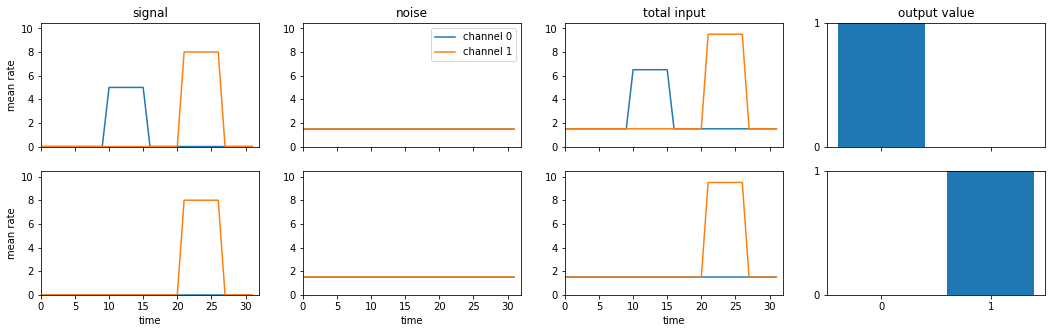

In [ ]:
#@title Solution part I
import matplotlib.pyplot as plt
from delay_task_dataloader import DelayTask

params_data = {'pulse_width': 6, 'offset_start': 10,  'offset_stop': 5, 
               'delay': 11, 'signal_strength': [[5.0, 8.0], [1.0, 1.0]], 
               'noise_strength': [1.5, 1.0]}

delay_task = DelayTask(**params_data)

fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(18, 5))
for i in range(2):
    ax[i][0].plot(delay_task.rate_profiles_signal[i, :, 0], label='channel 0')
    ax[i][0].plot(delay_task.rate_profiles_signal[i, :, 1], label='channel 1')
    ax[i][1].plot(delay_task.rate_profiles_noise[i, :, 0], label='channel 0')
    ax[i][1].plot(delay_task.rate_profiles_noise[i, :, 1], label='channel 1')
    input_class_0 = delay_task.rate_profiles_signal[i, :, 0] 
    input_class_0 += delay_task.rate_profiles_noise[i, :, 0]
    ax[i][2].plot(input_class_0)
    input_class_1 = delay_task.rate_profiles_signal[i, :, 1]
    input_class_1 += delay_task.rate_profiles_noise[i, :, 1]
    ax[i][2].plot(input_class_1)
    ax[i][3].get_shared_x_axes().remove(ax[i][3])
    ax[i][3].get_shared_y_axes().remove(ax[i][3])
    weight = [0, 0]
    weight[i] = 1
    ax[i][3].bar([0, 1], weight)
    ax[i][0].set_ylabel('mean rate')
    for j in range(3):
        ax[i][j].set_xlim([0, delay_task.duration])
        ymax = (delay_task.mean_values[1]+delay_task.mean_noise)*1.1
        ax[i][j].set_ylim([0, ymax])
        ax[0][j].set_xticklabels([])
        ax[1][j].set_xlabel('time')
    ax[i][3].set_xlim([-0.5, 1.5])
    ax[i][3].set_ylim([0, 1])
    ax[i][3].set_xticks([0, 1])
    ax[i][3].set_xticklabels([])
    ax[i][3].set_yticks([0, 1])
ax[0][0].set_title('signal')
ax[0][1].set_title('noise')
ax[0][2].set_title('total input')
ax[0][3].set_title('output value')
ax[1][3].set_xticklabels([0, 1])
ax[0][1].legend();

In [1]:
#@title Exercise part II
# Part II: visualize discrete/spiking realization of the stimuli

# TODO: visualize some samples of the input for each class. You can get the 
# samples either from the DelayTask class or by using the create_dataloaders() 
# function

params_data = {'pulse_width': 20, 'offset_start': 10,  'offset_stop': 5, 
               'delay': 50, 'signal_strength': [[1.5, 1.5], [0.1, 0.1]], 
               'noise_strength': [0.15, 0.15]}

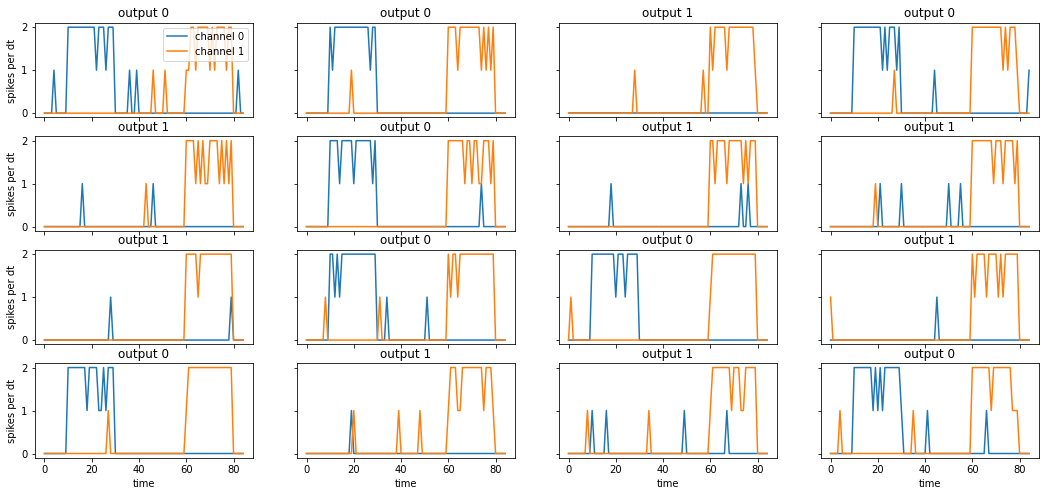

In [ ]:
#@title Solution part II
# Part II: visualize discrete/spiking realization of the stimuli

params_data = {'pulse_width': 20, 'offset_start': 10,  'offset_stop': 5, 
               'delay': 50, 'signal_strength': [[1.5, 1.5], [0.1, 0.1]], 
               'noise_strength': [0.15, 0.15]}

delay_task = DelayTask(**params_data)

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(18, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        signal, label = delay_task.__getitem__(0)
        ax[i][j].plot(signal[:, 0], label='channel 0')
        ax[i][j].plot(signal[:, 1], label='channel 1')
        ax[i][j].set_title('output ' + str(label[0]))
        ax[3][j].set_xlabel('time')
    ax[i][0].set_ylabel('spikes per dt')
ax[0][0].legend();

## SynNet: an SNN with synpatic currents

### Build the model

In [ ]:
#@title Exercise
%%writefile synnet.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

from rockpool.nn.modules import TorchModule, Module
from rockpool.nn.modules import LinearTorch, LIFBitshiftTorch
from rockpool.parameters import Constant
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential
from rockpool.graph import GraphHolder, connect_modules

import torch

from typing import List

__all__ = ["SynNet"]

class SynNet(TorchModule):

    def __init__(
        self,
        n_classes: int = 2,     
        n_channels: int = 2,       
        tau_syn_hidden: List = [2e-3],
        tau_mem: float = 2e-3,
        tau_syn_out: float = 2e-3,
        threshold: float = 1.0,
        neuron_model: TorchModule = LIFBitshiftTorch,
        max_spikes_per_dt: int = torch.inf,
        max_spikes_per_dt_out: int = torch.inf,
        dt: float = 1e-3,
        record: bool = False,
        *args,
        **kwargs,
    ):
        """
        Args:
            :param int n_classes:            number of output classes
            :param int n_channels:           number of input channels
            :param List tau_syn_hidden:      list of synaptic time constants of 
                                             hidden layer neurons 
            :param float tau_syn_out:        synaptic time constants of output
                                             neurons 
            :param float tau_mem:            membrane time constant of all 
                                             neurons
            :param float threshold:          threshold of all neurons
            :param TorchModule neuron_model: neuron model of all neurons
            :param max_spikes_per_dt:        maximum number of spikes per time
                                             step of all neurons apart from 
                                             output neurons
            :param max_spikes_per_dt_out:    maximum number of spikes per time
                                             step of output neurons
            :param float dt:                 one time step is seconds
            :param bool record:              determines of neuronal state such 
                                             as membrane potential and synaptic
                                             currents are recorded
        """

        super().__init__(
            shape=(n_channels, n_classes), spiking_input=True, 
            spiking_output=True, *args, **kwargs
        )

        n_hidden = len(tau_syn_hidden)
        tau_syn_hidden = torch.tensor(tau_syn_hidden)
        thresholds = Constant([threshold for i in range(n_hidden)])

        # TODO: initialize a linear weight layer that maps the input to the
        # hidden layer (set the bias to False, has_bias=False)

        # TODO: initalize the weights such that they are scaled by the
        # synpatic time constants (multiply weights by dt / tau_syn_hidden)

        setattr(self, 'lin', self.lin)

        # TODO: initialize the neuron model for the hidden neurons
        # - set the shape (n_hidden inputs are maped to n_hidden neurons)
        # - set the synaptic time constants and thresholds as arrays (make sure
        #   that they are wrapped by Constant() such that they are not trained)
        # - set the membrane time constant, bias as scalars (make sure
        #   that they are wrapped by Constant() such that they are not trained)
        # - set dt and maximum number of spikes
        # - set the function that is used for the surrogate gradient
        #    -> spike_generation_fn=PeriodicExponential
        
        setattr(self, 'spk', self.spk)

        # TODO: initialize a linear weight layer that maps the activity of the 
        # hidden layer to the output neurons (set the bias to False)
        
        # TODO: initalize the weights such that they are scaled by the
        # synpatic time constants (multiply weights by dt / tau_syn_out)
       

        # TODO: initialize the neuron model for the output neurons
        # - set the shape (n_classes inputs are maped to n_classes neurons)
        # - set the synaptic time constant, membrane time constant, bias as 
        #   scalars (make sure that they are wrapped by Constant() such that 
        #   they are not trained)
        # - set the threshold very high and constant (we don't want the output 
        #   neurons to spike in the training loop) 
        # - set dt and maximum number of spikes
        # - set the function that is used for the surrogate gradient
        #    -> spike_generation_fn=PeriodicExponential
        

        # Dictionary for recording state
        self._record = record
        self._record_dict = {}

    def forward(self, data: torch.Tensor):

        # hidden layer
        # TODO: pass data through the linear layer, make sure that all state 
        # variables are recorded (set the parameter record)
        
        # TODO: pass the output of the linear layer through the spike layer, 
        # make sure that all state variables are recorded
        

        # readout layer
        # TODO: pass the output of the hidden layer through the readout layer
       
   
        return out

    def evolve(self, input_data, record: bool = False):
        # - Store "record" state
        self._record = record

        # - Evolve network
        output, new_state, _ = super().evolve(input_data, record=self._record)

        # - Get recording dictionary
        record_dict = self._record_dict if self._record else {}

        # - Return
        return output, new_state, record_dict

    def as_graph(self):
        # convert all modules to graph representation
        mod_graphs = {k: m.as_graph() for k, m in Module.modules(self).items()}

        # connect modules
        connect_modules(mod_graphs["lin"], mod_graphs["spk"])
        connect_modules(mod_graphs["spk"], mod_graphs["lin_out"])
        connect_modules(mod_graphs["lin_out"], mod_graphs["spk_out"])

        return GraphHolder(
            mod_graphs["lin"].input_nodes,
            mod_graphs["spk_out"].output_nodes,
            f"{type(self).__name__}_{self.name}_{id(self)}",
            self,
        )

Overwriting synnet.py


In [ ]:
#@title Solution
%%writefile synnet.py
##### SCRIPT STARTS HERE #####
#!usr/bin/bash python

from rockpool.nn.modules import TorchModule, Module
from rockpool.nn.modules import LinearTorch, LIFBitshiftTorch
from rockpool.parameters import Constant
from rockpool.nn.modules.torch.lif_torch import PeriodicExponential
from rockpool.graph import GraphHolder, connect_modules

import torch

from typing import List

__all__ = ["SynNet"]

class SynNet(TorchModule):

    def __init__(
        self,
        n_classes: int = 2,     
        n_channels: int = 2,       
        tau_syn_hidden: List = [2e-3],
        tau_mem: float = 2e-3,
        tau_syn_out: float = 2e-3,
        threshold: float = 1.0,
        neuron_model: TorchModule = LIFBitshiftTorch,
        max_spikes_per_dt: int = torch.inf,
        max_spikes_per_dt_out: int = torch.inf,
        dt: float = 1e-3,
        record: bool = False,
        *args,
        **kwargs,
    ):
        """
        Args:
            :param int n_classes:            number of output classes
            :param int n_channels:           number of input channels
            :param List tau_syn_hidden:      list of synaptic time constants of 
                                             hidden layer neurons 
            :param float tau_syn_out:        synaptic time constants of output
                                             neurons 
            :param float tau_mem:            membrane time constant of all 
                                             neurons
            :param float threshold:          threshold of all neurons
            :param TorchModule neuron_model: neuron model of all neurons
            :param max_spikes_per_dt:        maximum number of spikes per time
                                             step of all neurons apart from 
                                             output neurons
            :param max_spikes_per_dt_out:    maximum number of spikes per time
                                             step of output neurons
            :param float dt:                 one time step is seconds
            :param bool record:              determines of neuronal state such 
                                             as membrane potential and synaptic
                                             currents are recorded
        """

        super().__init__(
            shape=(n_channels, n_classes), spiking_input=True, 
            spiking_output=True, *args, **kwargs
        )

        n_hidden = len(tau_syn_hidden)
        tau_syn_hidden = torch.tensor(tau_syn_hidden)
        thresholds = Constant([threshold for i in range(n_hidden)])

        # TODO: initialize a linear weight layer that maps the input to the
        # hidden layer (set the bias to False, has_bias=False)
        self.lin = LinearTorch(shape=(n_channels, n_hidden), has_bias=False)
        # TODO: initalize the weights such that they are scaled by the
        # synpatic time constants (multiply weights by dt / tau_syn_hidden)
        with torch.no_grad():
            self.lin.weight.data = self.lin.weight.data * dt / tau_syn_hidden
        setattr(self, 'lin', self.lin)

        # TODO: initialize the neuron model for the hidden neurons
        # - set the shape (n_hidden inputs are maped to n_hidden neurons)
        # - set the synaptic time constants and thresholds as arrays (make sure
        #   that they are wrapped by Constant() such that they are not trained)
        # - set the membrane time constant, bias as scalars (make sure
        #   that they are wrapped by Constant() such that they are not trained)
        # - set dt and maximum number of spikes
        # - set the function that is used for the surrogate gradient
        #    -> spike_generation_fn=PeriodicExponential
        self.spk = neuron_model(shape=(n_hidden, n_hidden),
                                     tau_mem=Constant(tau_mem),
                                     tau_syn=Constant(tau_syn_hidden),
                                     bias=Constant(0.0),
                                     threshold=thresholds,
                                     spike_generation_fn=PeriodicExponential,
                                     dt=dt,
                                     max_spikes_per_dt=max_spikes_per_dt)
        setattr(self, 'spk', self.spk)

        # TODO: initialize a linear weight layer that maps the activity of the 
        # hidden layer to the output neurons (set the bias to False)
        self.lin_out = LinearTorch(shape=(n_hidden, n_classes), has_bias=False)
        # TODO: initalize the weights such that they are scaled by the
        # synpatic time constants (multiply weights by dt / tau_syn_out)
        with torch.no_grad():
            self.lin_out.weight.data = self.lin_out.weight.data * dt / tau_syn_out

        # TODO: initialize the neuron model for the output neurons
        # - set the shape (n_classes inputs are maped to n_classes neurons)
        # - set the synaptic time constant, membrane time constant, bias as 
        #   scalars (make sure that they are wrapped by Constant() such that 
        #   they are not trained)
        # - set the threshold very high and constant (we don't want the output 
        #   neurons to spike in the training loop) 
        # - set dt and maximum number of spikes
        # - set the function that is used for the surrogate gradient
        #    -> spike_generation_fn=PeriodicExponential
        self.spk_out = neuron_model(
            shape=(n_classes, n_classes),
            tau_mem=Constant(tau_mem),
            tau_syn=Constant(tau_syn_out),
            bias=Constant(0.0),
            threshold=Constant(100.0),
            spike_generation_fn=PeriodicExponential,
            max_spikes_per_dt=max_spikes_per_dt_out,
            dt=dt,
        )

        # Dictionary for recording state
        self._record = record
        self._record_dict = {}

    def forward(self, data: torch.Tensor):

        # hiddeb layer
        # TODO: pass data through the linear layer, make sure that all state 
        # variables are recorded (set the parameter record)
        out, _, self._record_dict["lin"] = self.lin(data, record=self._record)
        # TODO: pass the output of the linear layer through the spike layer, 
        # make sure that all state variables are recorded
        out, _, self._record_dict["spk"] = self.spk(out, record=self._record)

        # readout layer
        # TODO: pass the output of the hidden layer through the readout layer
        out, _, self._record_dict["lin_out"] = self.lin_out(out, 
                                                            record=self._record)
        out, _, self._record_dict["spk_out"] = self.spk_out(out, 
                                                            record=self._record)

        return out

    def evolve(self, input_data, record: bool = False):
        # - Store "record" state
        self._record = record

        # - Evolve network
        output, new_state, _ = super().evolve(input_data, record=self._record)

        # - Get recording dictionary
        record_dict = self._record_dict if self._record else {}

        # - Return
        return output, new_state, record_dict

    def as_graph(self):
        # convert all modules to graph representation
        mod_graphs = {k: m.as_graph() for k, m in Module.modules(self).items()}

        # connect modules
        connect_modules(mod_graphs["lin"], mod_graphs["spk"])
        connect_modules(mod_graphs["spk"], mod_graphs["lin_out"])
        connect_modules(mod_graphs["lin_out"], mod_graphs["spk_out"])

        return GraphHolder(
            mod_graphs["lin"].input_nodes,
            mod_graphs["spk_out"].output_nodes,
            f"{type(self).__name__}_{self.name}_{id(self)}",
            self,
        )

Overwriting synnet.py


### Explore the untrained model


In [ ]:
import delay_task_dataloader as dtd
from synnet import SynNet

# ------------
# data
# ------------
offset_start = 10
offset_stop = 5
pulse_width = 20
delay = 50
duration_stimulus = offset_start + offset_stop + pulse_width + delay 
t_second_pulse = offset_start + delay
params_delay_task = {'pulse_width': pulse_width, 'offset_start': offset_start,
                     'offset_stop': offset_stop, 'max_spikes_per_dt': 15,
                     'signal_strength': [[1.5, 1.5], [0.1, 0.1]],
                     'noise_strength': [0.15, 0.15], 'delay': delay}
batch_size = 100
dataloaders = dtd.create_dataloaders(params_delay_task=params_delay_task, 
                                     batch_size=batch_size, num_workers=2, 
                                     size_dataset=10000)
train_loader, val_loader, test_loader = dataloaders

# load one data batch
data_test, labels_test = next(iter(test_loader)) 


# ------------
# model
# ------------
n_classes = 2
dt = 1e-3
tau_syn_hidden = [2., 4., 8., 16., 32., 64.]
snn_untrained = SynNet(n_classes=n_classes, n_channels=2, 
             tau_syn_hidden=[tau * dt for tau in tau_syn_hidden], 
             tau_mem=2. * dt, tau_syn_out=2. * dt,
             threshold=0.4, dt=dt,  max_spikes_per_dt=31, 
             max_spikes_per_dt_out=1)

/usr/local/lib/python3.7/dist-packages/rockpool/nn/modules/torch/lif_torch.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()


In [ ]:
#@title Exercise
# run one signal type of each class through the model and visualize the 
# input signal, the spikes produced by the neurons in the hidden layer and the
# membrane potential and spikes of the output neurons

import torch
import torchmetrics
from tqdm.auto import tqdm

# process data with model
with torch.no_grad():
  _, _,  rec_untrained = snn_untrained(data_test.float(), record=True)

# TODO: read out spikes of the hidden layer and membrane potential and spikes
# of the output neurons from the recording dictionary
# spikes_hidden = ...
# vmem_out = ...
# spikes_out = ...

'''
# pick the first signals in the batch corresponding to target values 0 and 1
t0, t1 = 0, 1
batch_idx_c0 = torch.range(0, batch_size-1, dtype=int)[labels[:, 0] == t0][0].item()
batch_idx_c1 = torch.range(0, batch_size-1, dtype=int)[labels[:, 0] == t1][0].item()

# visualize activity in layers
fig, ax = plt.subplots(4, 2, figsize=(10, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].plot(data_test[batch_idx_c1])
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect='auto')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][1].imshow(spikes_hidden[batch_idx_c1].T, aspect='auto')
fig.colorbar(img, ax=ax[1][1])
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect='auto')
fig.colorbar(img, ax=ax[2][0])
img = ax[2][1].imshow(vmem_out[batch_idx_c1].T, aspect='auto')
fig.colorbar(img, ax=ax[2][1])

ax[3][0].set_ylabel('spikes_out')
img = ax[3][0].imshow(spikes_out[batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][0]) 
img = ax[3][1].imshow(spikes_out[batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][1]) 

for i in range(2):  
  ax[3][i].set_xlabel("Time")

plt.show()
'''

# TODO: check that the output neurons of the model produce spikes if their 
# threshold is lowered
# -> set snn_untrained.spk_out.threshold = torch.tensor(new_threshold)
# why does lowering the spiking threshold also change the membrane potential?

'\n# pick the first signals in the batch corresponding to target values 0 and 1\nt0, t1 = 0, 1\nbatch_idx_c0 = torch.range(0, batch_size-1, dtype=int)[labels[:, 0] == t0][0].item()\nbatch_idx_c1 = torch.range(0, batch_size-1, dtype=int)[labels[:, 0] == t1][0].item()\n\n# visualize activity in layers\nfig, ax = plt.subplots(4, 2, figsize=(10, 8), constrained_layout=True, \n                       sharex=True)\n\n# plot stimuli\nax[0][0].plot(data_test[batch_idx_c0])\nax[0][1].plot(data_test[batch_idx_c1])\n   \nax[1][0].set_ylabel(\'spikes_hidden\')\nimg = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect=\'auto\')\nfig.colorbar(img, ax=ax[1][0])\nimg = ax[1][1].imshow(spikes_hidden[batch_idx_c1].T, aspect=\'auto\')\nfig.colorbar(img, ax=ax[1][1])\n    \nax[2][0].set_ylabel(\'vmem_out\')\nimg = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect=\'auto\')\nfig.colorbar(img, ax=ax[2][0])\nimg = ax[2][1].imshow(vmem_out[batch_idx_c1].T, aspect=\'auto\')\nfig.colorbar(img, ax=ax[2][1])\n\n

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


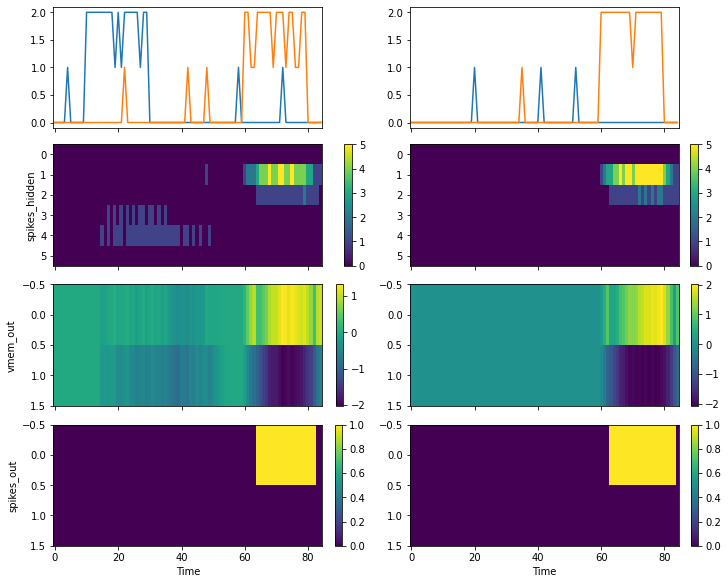

In [ ]:
#@title Solution
# run one signal type of each class through the model and visualize the 
# input signal, the spikes produced by the neurons in the hidden layer and the
# membrane potential and spikes of the output neurons

import torch
import torchmetrics
from tqdm.auto import tqdm

# lower the threshold of the readout neurons
snn_untrained.spk_out.threshold = torch.tensor(1.1)

# process data with model
with torch.no_grad():
  snn_untrained.reset_state()
  _, _,  rec_untrained = snn_untrained(data_test.float(), record=True)

# TODO: read out spikes of the hidden layer and membrane potential and spikes
# of the output neurons from the recording dictionary
spikes_hidden = rec_untrained['spk']['spikes'].detach().cpu().numpy()
vmem_out = rec_untrained['spk_out']['vmem'].detach().cpu().numpy()
spikes_out = rec_untrained['spk_out']['spikes'].detach().cpu().numpy()

# pick the first signals in the batch corresponding to target values 0 and 1
t0, t1 = 0, 1
batch_idx_c0 = torch.range(0, batch_size-1, dtype=int)[labels_test[:, 0] == t0][0].item()
batch_idx_c1 = torch.range(0, batch_size-1, dtype=int)[labels_test[:, 0] == t1][0].item()

# visualize activity in layers
fig, ax = plt.subplots(4, 2, figsize=(10, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].plot(data_test[batch_idx_c1])
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect='auto')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][1].imshow(spikes_hidden[batch_idx_c1].T, aspect='auto')
fig.colorbar(img, ax=ax[1][1])
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect='auto')
fig.colorbar(img, ax=ax[2][0])
img = ax[2][1].imshow(vmem_out[batch_idx_c1].T, aspect='auto')
fig.colorbar(img, ax=ax[2][1])

ax[3][0].set_ylabel('spikes_out')
img = ax[3][0].imshow(spikes_out[batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][0]) 
img = ax[3][1].imshow(spikes_out[batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][1]) 

for i in range(2):  
  ax[3][i].set_xlabel("Time")

plt.show()

# TODO: check that the output neurons of the model produce spikes if their 
# threshold is lowered
# -> set snn_untrained.spk_out.threshold = torch.tensor(new_threshold)
# why does lowering the spiking threshold also change the membrane potential?

### Train the model

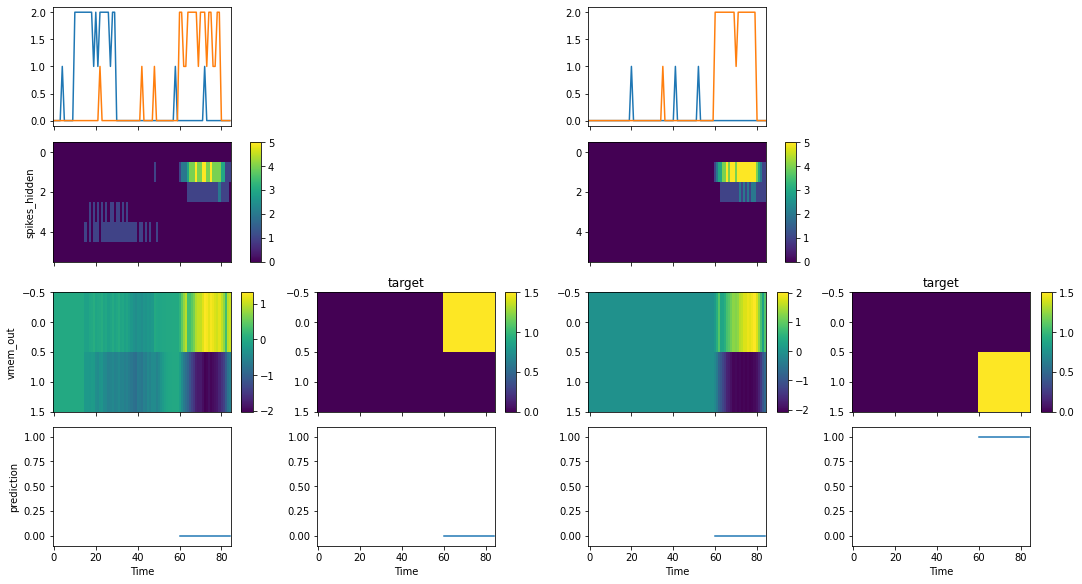

In [ ]:
#@title The loss function

# We provide a target function for the membrane potential. This is easier to 
# optimize since the membrane potential is continues while the spikes are
# discontinues and thus give a discontinues loss surface.
# Before onset of the second stimulus the readout neurons should be silent and 
# we set the membrane potential to zero (readout_floor). After presentation of 
# the second pulse the membrane potential of the correct readout neurons is set
# to 1.5 (readout_target) and the other ine remains zero.

def targets_over_time(labels, readout_floor, readout_target):
    time_steps_after_second_pulse = duration_stimulus - t_second_pulse
    labels_over_time = labels.repeat(1, time_steps_after_second_pulse)
    vmem_target_after_stim = torch.nn.functional.one_hot(labels_over_time)
    vmem_target_after_stim = vmem_target_after_stim * readout_target
    vmem_target_after_stim[vmem_target_after_stim == 0] = readout_floor
    vmem_target_before_stim = torch.ones((batch_size, t_second_pulse, n_classes))
    vmem_target_before_stim = vmem_target_before_stim * readout_floor
    vmem_target = [vmem_target_before_stim, vmem_target_after_stim]
    return labels_over_time, vmem_target

labels_over_time, vmem_target = targets_over_time(labels_test, 0.0, 1.5)
vmem_target  = torch.cat((vmem_target[0], vmem_target[1]), 1)

# visualize activity in layers
fig, ax = plt.subplots(4, 4, figsize=(15, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].axis('off')
ax[0][2].plot(data_test[batch_idx_c1])
ax[0][3].axis('off')
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[batch_idx_c0].T, aspect='auto', 
                      interpolation='none')
ax[1][1].axis('off')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][2].imshow(spikes_hidden[batch_idx_c1].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][2])
ax[1][3].axis('off')
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[batch_idx_c0].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][0])
ax[2][1].set_title('target')
img = ax[2][1].imshow(vmem_target[batch_idx_c0].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][1])
img = ax[2][2].imshow(vmem_out[batch_idx_c1].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][2])
ax[2][3].set_title('target')
img = ax[2][3].imshow(vmem_target[batch_idx_c1].T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][3]) 

ax[3][0].set_ylabel('prediction')
predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
ax[3][0].plot(range(t_second_pulse, duration_stimulus), predictions[batch_idx_c0])
ax[3][1].plot(range(t_second_pulse, duration_stimulus), labels_over_time[batch_idx_c0])
ax[3][2].plot(range(t_second_pulse, duration_stimulus), predictions[batch_idx_c1])
ax[3][3].plot(range(t_second_pulse, duration_stimulus), labels_over_time[batch_idx_c1])

for i in range(4): 
  ax[3][i].set_ylim([-0.1, 1.1]) 
  ax[3][i].set_xlabel("Time")

plt.show()

In [ ]:
#@title Exercise: training
import torch
import torchmetrics
from tqdm.auto import tqdm

from synnet import SynNet


# ------------
# model
# ------------
n_classes = 2
dt = 1e-3
tau_syn_hidden = [2., 4., 8., 16., 32., 64.]
snn = SynNet(n_classes=n_classes, n_channels=2, 
             tau_syn_hidden=[tau * dt for tau in tau_syn_hidden], 
             tau_mem=2. * dt, tau_syn_out=2. * dt,
             threshold=0.4, dt=dt,  max_spikes_per_dt=31, 
             max_spikes_per_dt_out=1)

# ------------
# training
# ------------

# TODO: use MSE loss 
# criterion = ...

# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0
# learning rate of target readout neuron takes decision compared to after
# this determined how much we force both readout neurons to be silent before 
# the secodn pulse comes in
alpha_pre_pulse = 0.5

# TODO: use the ADAM optimizer, try a learning rate of 0.005
# optimizer = ...

# TODO: use accuracy as the metric
# metric = ...

num_epochs = 100
val_acc_stop = 0.95

# track losses
training_losses, training_accs, val_losses, val_accs = [], [], [], []

'''
pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    training_batch_loss, training_batch_acc = [], []
    val_batch_loss, val_batch_acc = [], []
    for data, labels in iter(train_loader):

        # TODO: get targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        
        # reset state of model and optimizer
        snn.reset_state()
        optimizer.zero_grad()
        
        # forward pass
        # TODO: feed the data into the model and readout the recording 
        # dictionary
        # _, _,  rec = ...

        # read out membrane potential of readout neurons
        # TODO: readout the membrane potential of the readout neurons
        # vmem_out = ...

        # TODO: define the loss function
        #       1. the membrane potential before t_second_pulse should be 
        #          vmem_target[0]
        #       2. the membrane potential after t_second_pulse should be 
        #          vmem_target[1]
        #       3. add the two loss terms and weigh the loss before the second
        #          pulse with alpha_pre_pulse
        # loss = ...

        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        training_batch_loss.append(loss.item())

        # accuracy
        # TODO: get predictions for all time steps after the second pulse from
        # the membrane potential
        # predictions = ...

        # TODO: get acccuracy by evaluating the metric between predictions and 
        # labels over time
        acc = metric(predictions, labels_over_time)
        training_batch_acc.append(acc.item())

    training_losses.append(sum(training_batch_loss) / len(training_batch_loss))
    training_accs.append(sum(training_batch_acc) / len(training_batch_acc))
    
    # validation
    with torch.no_grad():
      batch_loss = []
      for data, labels in iter(val_loader):

        # TODO: get targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        # reset state of model
        snn.reset_state()

        # TODO: feed the data into the model and readout the recording 
        # dictionary
        # _, _,  rec = ...
        # vmem_out = ...

        # TODO: define the loss function
        #       1. the membrane potential before t_second_pulse should be 
        #          vmem_target[0]
        #       2. the membrane potential after t_second_pulse should be 
        #          vmem_target[1]
        #       3. add the two loss terms and weigh the loss before the second
        #          pulse with alpha_pre_pulse
        # loss = ...

        val_batch_loss.append(loss.item())

        # accuracy
        # TODO: get predictions for all time steps after the second pulse from
        # the membrane potential
        predictions = ...

        # TODO: get acccuracy by. evaluating the metric between predictions and 
        # labels over time
        acc = metric(predictions, labels_over_time)
        val_batch_acc.append(acc.item())
            
    val_losses.append(sum(val_batch_loss) / len(val_batch_loss))
    val_accs.append(sum(val_batch_acc) / len(val_batch_acc))
            
    pbar_epoch.set_postfix(train_loss=training_losses[-1], 
                           val_loss=val_losses[-1], 
                           val_acc=val_accs[-1])
    if val_accs[-1] >= val_acc_stop:
      break

'''

/usr/local/lib/python3.7/dist-packages/rockpool/nn/modules/torch/lif_torch.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()


'\npbar_epoch = tqdm(range(num_epochs), desc="Epochs")\nfor epoch in pbar_epoch:\n    training_batch_loss, training_batch_acc = [], []\n    val_batch_loss, val_batch_acc = [], []\n    for data, labels in iter(train_loader):\n\n        # TODO: get targets for the membrane potentials of the readout neurons\n        labels_over_time, vmem_target = targets_over_time(labels, \n                                                          readout_floor, \n                                                          readout_target)\n        \n        # reset state of model and optimizer\n        snn.reset_state()\n        optimizer.zero_grad()\n        \n        # forward pass\n        # TODO: feed the data into the model and readout the recording \n        # dictionary\n        # _, _,  rec = ...\n\n        # read out membrane potential of readout neurons\n        # TODO: readout the membrane potential of the readout neurons\n        # vmem_out = ...\n\n        # TODO: define the loss function\n   

In [ ]:
#@title Solution
import torch
import torchmetrics
from tqdm.auto import tqdm

from synnet import SynNet


# ------------
# model
# ------------
n_classes = 2
dt = 1e-3
tau_syn_hidden = [2., 4., 8., 16., 32., 64.]
snn = SynNet(n_classes=n_classes, n_channels=2, 
             tau_syn_hidden=[tau * dt for tau in tau_syn_hidden], 
             tau_mem=2. * dt, tau_syn_out=2. * dt,
             threshold=0.4, dt=dt,  max_spikes_per_dt=31, 
             max_spikes_per_dt_out=1)

# ------------
# training
# ------------
# TODO: use MSE loss 
criterion = torch.nn.MSELoss()
# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0
# learning rate of target readout neuron takes decision compared to after
# this determined how much we force both readout neurons to be silent before 
# the secodn pulse comes in
alpha_pre_pulse = 0.5

# TODO: use the ADAM optimizer, try a learning rate of 0.005
optimizer = torch.optim.Adam(snn.parameters().astorch(), lr=0.0005)

# TODO: use accuracy as the metric
metric = torchmetrics.Accuracy()

num_epochs = 100
val_acc_stop = 0.95

# track losses
training_losses, training_accs, val_losses, val_accs = [], [], [], []

pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    training_batch_loss, training_batch_acc = [], []
    val_batch_loss, val_batch_acc = [], []
    for data, labels in iter(train_loader):
        # TODO: get targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        # reset state of model and optimizer
        snn.reset_state()
        optimizer.zero_grad()
        # forward pass
        # TODO: feed the data into the model and readout the recording 
        # dictionary
        _, _,  rec = snn(data.float(), record=True)
        # read out membrane potential of readout neurons
        # TODO: readout the membrane potential of the readout neurons
        vmem_out = rec['spk_out']['vmem']
        # TODO: define the loss function
        #       1. the membrane potential before t_second_pulse should be 
        #          vmem_target[0]
        #       2. the membrane potential after t_second_pulse should be 
        #          vmem_target[1]
        #       3. add the two loss terms and weigh the loss before the second
        #          pulse with alpha_pre_pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        training_batch_loss.append(loss.item())

        # accuracy
        # TODO: get predictions for all time steps after the second pulse from
        # the membrane potential
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        # TODO: get acccuracy by. evaluating the metric between predictions and 
        # labels over time
        acc = metric(predictions, labels_over_time)
        training_batch_acc.append(acc.item())

    training_losses.append(sum(training_batch_loss) / len(training_batch_loss))
    training_accs.append(sum(training_batch_acc) / len(training_batch_acc))
    
    # validation
    with torch.no_grad():
      batch_loss = []
      for data, labels in iter(val_loader):
        # TODO: get targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        # reset state of model
        snn.reset_state()
        # TODO: feed the data into the model and readout the recording 
        # dictionary
        _, _,  rec = snn(data.float(), record=True)
        vmem_out = rec['spk_out']['vmem']
        # TODO: define the loss function
        #       1. the membrane potential before t_second_pulse should be 
        #          vmem_target[0]
        #       2. the membrane potential after t_second_pulse should be 
        #          vmem_target[1]
        #       3. add the two loss terms and weigh the loss before the second
        #          pulse with alpha_pre_pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])
        val_batch_loss.append(loss.item())

        # accuracy
        # TODO: get predictions for all time steps after the second pulse from
        # the membrane potential
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        # TODO: get acccuracy by. evaluating the metric between predictions and 
        # labels over time
        acc = metric(predictions, labels_over_time)
        val_batch_acc.append(acc.item())
            
    val_losses.append(sum(val_batch_loss) / len(val_batch_loss))
    val_accs.append(sum(val_batch_acc) / len(val_batch_acc))
            
    pbar_epoch.set_postfix(train_loss=training_losses[-1], 
                           val_loss=val_losses[-1], 
                           val_acc=val_accs[-1])
    if val_accs[-1] >= val_acc_stop:
      break

/usr/local/lib/python3.7/dist-packages/rockpool/nn/modules/torch/lif_torch.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#@title Exercise: visualize loss function
# TODO: visualize training/validation loss and training/validation accuracy

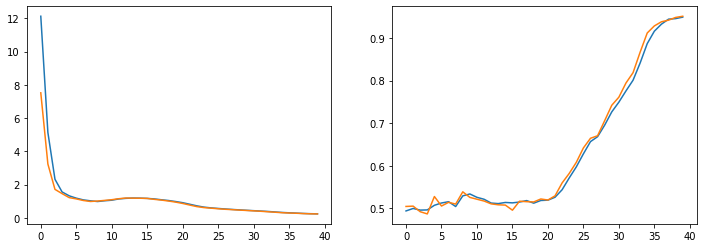

In [ ]:
#@title Solution
# TODO: visualize training/validation loss and training/validation accuracy

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(training_losses)
ax[0].plot(val_losses)
ax[1].plot(training_accs)
ax[1].plot(val_accs)

### Explore the trained model

> Indented block



In [ ]:
#@title Exercise: visualize activity

# TODO: visualize activity of trained model
# 1. Pass one batch of the test data through the model and visualize spiking 
#    activity of hidden neurons and spikes and membrane potentials of readout 
#    neurons. Pick one sample for each class. 
#    Hint: use visualization of untrained model and add panels for trained model
#    Hint: remember to reset_state() the models before processing data
# 2. lower the threshold of the readout neurons and show how their spiking can
#    be used to classify the input

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


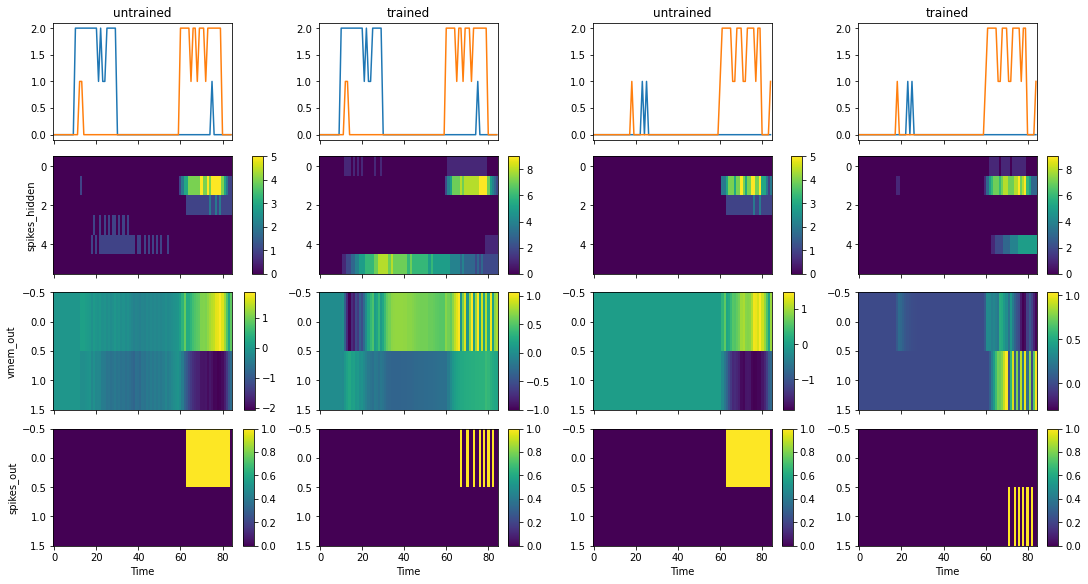

In [ ]:
#@title Solution 

# TODO: visualize activity of trained model
# 1. Pass one batch of the test data through the model and visualize spiking 
#    activity of hidden neurons and spikes and membrane potentials of readout 
#    neurons. Pick one sample for each class. 
#    Hint: use visualization of untrained model and add panels for trained model
#    Hint: remember to reset_state() the models before processing data
# 2. lower the threshold of the readout neurons and show how their spiking can
#    be used to classify the input

# set threshold of readout neurons to signal class
snn.spk_out.threshold = torch.tensor(1.1)
snn_untrained.spk_out.threshold = torch.tensor(1.1)

data, labels = next(iter(test_loader)) 
with torch.no_grad():
  snn.reset_state()
  _, _,  rec = snn(data.float(), record=True)
  snn_untrained.reset_state()
  _, _,  rec_untrained = snn_untrained(data.float(), record=True)

spikes_hidden = [rec_untrained['spk']['spikes'].detach().cpu().numpy(), 
                 rec['spk']['spikes'].detach().cpu().numpy()]
vmem_out = [rec_untrained['spk_out']['vmem'].detach().cpu().numpy(),
            rec['spk_out']['vmem'].detach().cpu().numpy()]
spikes_out = [rec_untrained['spk_out']['spikes'].detach().cpu().numpy(), 
              rec['spk_out']['spikes'].detach().cpu().numpy()]

batch_idx_c0 = torch.range(0, batch_size-1, dtype=int)[labels[:, 0] == 0][1].item()
batch_idx_c1 = torch.range(0, batch_size-1, dtype=int)[labels[:, 0] == 1][1].item()

fig, ax = plt.subplots(4, 4, figsize=(15, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data[batch_idx_c0])
ax[0][1].plot(data[batch_idx_c0])
ax[0][2].plot(data[batch_idx_c1])
ax[0][3].plot(data[batch_idx_c1])
ax[0][0].set_title('untrained')
ax[0][1].set_title('trained')
ax[0][2].set_title('untrained')
ax[0][3].set_title('trained')
   
ax[1][0].set_ylabel('spikes_hidden')
img = ax[1][0].imshow(spikes_hidden[0][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][1].imshow(spikes_hidden[1][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][1])
img = ax[1][2].imshow(spikes_hidden[0][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][2])
img = ax[1][3].imshow(spikes_hidden[1][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[1][3])
    
ax[2][0].set_ylabel('vmem_out')
img = ax[2][0].imshow(vmem_out[0][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][0])
img = ax[2][1].imshow(vmem_out[1][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][1])
img = ax[2][2].imshow(vmem_out[0][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][2])
img = ax[2][3].imshow(vmem_out[1][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[2][3])

ax[3][0].set_ylabel('spikes_out')
img = ax[3][0].imshow(spikes_out[0][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][0]) 
img = ax[3][1].imshow(spikes_out[1][batch_idx_c0].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][1])
img = ax[3][2].imshow(spikes_out[0][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][2]) 
img = ax[3][3].imshow(spikes_out[1][batch_idx_c1].T, aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax[3][3])

for i in range(4):  
  ax[3][i].set_xlabel("Time")

plt.show()

In [ ]:
#@title Exercise: ablation experiments

# test the importance of neurons with different time constants for the accuracy 
# of the model
# -> remove one time constant at a time and create a bar plot with model
#    accuracies
# Hint: neurons do not contribute if their threshold is set high
# Hint: use get_acc() to obtain the accuracy for each model

def get_acc(dataloader, model):
    batch_acc = []
    for data, labels in iter(dataloader):
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        model.reset_state()
        _, _,  rec = model(data.float(), record=True)
        vmem_out = rec['spk_out']['vmem']
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)
        batch_acc.append(acc.item())

    return sum(batch_acc) / len(batch_acc)

# set the threshold of output neurons high to get correct accuray for membrane
# potentials
snn.spk_out.threshold = torch.tensor(100.0)

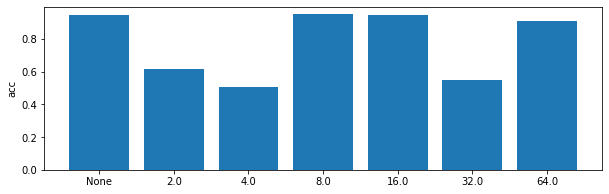

In [ ]:
#@title Solution

# test the importance of neurons with different time constants for the accuracy 
# of the model
# -> remove one time constant at a time and create a bar plot with model
#    accuracies
# Hint: neurons do not contribute if their threshold is set high
# Hint: use get_acc() to obtain the accuracy for each model

def get_acc(dataloader, model):
    batch_acc = []
    for data, labels in iter(dataloader):
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        model.reset_state()
        _, _,  rec = model(data.float(), record=True)
        vmem_out = rec['spk_out']['vmem']
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        acc = metric(predictions, labels_over_time)
        batch_acc.append(acc.item())

    return sum(batch_acc) / len(batch_acc)

# set the threshold of output neurons high to get correct accuray for membrane
# potentials
snn.spk_out.threshold = torch.tensor(100.0)

test_accs = []
test_accs.append(get_acc(test_loader, snn))
for i in range(len(tau_syn_hidden)):
    snn.spk.threshold[i] = 100.0 
    test_accs.append(get_acc(test_loader, snn))
    snn.spk.threshold[i] = 0.4
    
fig = plt.figure(figsize=(10, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar(range(len(tau_syn_hidden)+1), test_accs)
ax.set_xticks(range(len(tau_syn_hidden)+1))
ax.set_ylabel('removed time constant')
ax.set_ylabel('acc')
ax.set_xticklabels(['None'] + tau_syn_hidden);

### How important are the time constants?

In [ ]:
#@title Exercise 
# TODO: train a model with the same number of parameters as above but without
# larger time constants (tau_syn=2), check if the networks can still solve the 
# delay task

/usr/local/lib/python3.7/dist-packages/rockpool/nn/modules/torch/lif_torch.py:175: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_float_tensor = lambda x: torch.tensor(x).float()


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

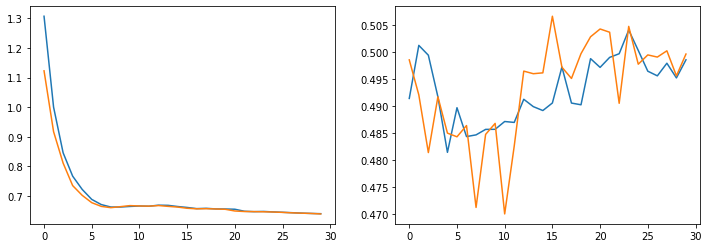

In [ ]:
#@title Solution
import torch
import torchmetrics
from tqdm.auto import tqdm

from synnet import SynNet


# ------------
# model
# ------------
n_classes = 2
dt = 1e-3
tau_syn_hidden = [2., 2., 2., 2., 2., 2.]
snn_small_tau = SynNet(n_classes=n_classes, n_channels=2, 
                       tau_syn_hidden=[tau * dt for tau in tau_syn_hidden], 
                       tau_mem=2. * dt, tau_syn_out=2. * dt,
                       threshold=0.4, dt=dt,  max_spikes_per_dt=31, 
                       max_spikes_per_dt_out=1)

# ------------
# training
# ------------
# TODO: use MSE loss 
criterion = torch.nn.MSELoss()
# define target values for the membrane potential of the readout neurons
readout_target = 1.5 
readout_floor = 0.0
# learning rate of target readout neuron takes decision compared to after
# this determined how much we force both readout neurons to be silent before 
# the secodn pulse comes in
alpha_pre_pulse = 0.5

# TODO: use the ADAM optimizer, try a learning rate of 0.005
optimizer = torch.optim.Adam(snn_small_tau.parameters().astorch(), lr=0.0005)

# TODO: use accuracy as the metric
metric = torchmetrics.Accuracy()

num_epochs = 30
val_acc_stop = 0.99

# track losses
training_losses, training_accs, val_losses, val_accs = [], [], [], []

pbar_epoch = tqdm(range(num_epochs), desc="Epochs")
for epoch in pbar_epoch:
    training_batch_loss, training_batch_acc = [], []
    val_batch_loss, val_batch_acc = [], []
    for data, labels in iter(train_loader):
        # TODO: get targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        # reset state of model and optimizer
        snn_small_tau.reset_state()
        optimizer.zero_grad()
        # forward pass
        # TODO: feed the data into the model and readout the recording 
        # dictionary
        _, _,  rec = snn_small_tau(data.float(), record=True)
        # read out membrane potential of readout neurons
        # TODO: readout the membrane potential of the readout neurons
        vmem_out = rec['spk_out']['vmem']
        # TODO: define the loss function
        #       1. the membrane potential before t_second_pulse should be 
        #          vmem_target[0]
        #       2. the membrane potential after t_second_pulse should be 
        #          vmem_target[1]
        #       3. add the two loss terms and weigh the loss before the second
        #          pulse with alpha_pre_pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])
        # backward pass
        loss.backward()
        # update parameters
        optimizer.step()
        training_batch_loss.append(loss.item())

        # accuracy
        # TODO: get predictions for all time steps after the second pulse from
        # the membrane potential
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        # TODO: get acccuracy by. evaluating the metric between predictions and 
        # labels over time
        acc = metric(predictions, labels_over_time)
        training_batch_acc.append(acc.item())

    training_losses.append(sum(training_batch_loss) / len(training_batch_loss))
    training_accs.append(sum(training_batch_acc) / len(training_batch_acc))
    
    # validation
    with torch.no_grad():
      batch_loss = []
      for data, labels in iter(val_loader):
        # TODO: get targets for the membrane potentials of the readout neurons
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        # reset state of model
        snn_small_tau.reset_state()
        # TODO: feed the data into the model and readout the recording 
        # dictionary
        _, _,  rec = snn_small_tau(data.float(), record=True)
        vmem_out = rec['spk_out']['vmem']
        # TODO: define the loss function
        #       1. the membrane potential before t_second_pulse should be 
        #          vmem_target[0]
        #       2. the membrane potential after t_second_pulse should be 
        #          vmem_target[1]
        #       3. add the two loss terms and weigh the loss before the second
        #          pulse with alpha_pre_pulse
        loss = alpha_pre_pulse*criterion(vmem_out[:, :t_second_pulse, :], 
                                         vmem_target[0])
        loss += criterion(vmem_out[:, t_second_pulse:, :], vmem_target[1])
        val_batch_loss.append(loss.item())

        # accuracy
        # TODO: get predictions for all time steps after the second pulse from
        # the membrane potential
        predictions = vmem_out[:, t_second_pulse:, :].argmax(2)
        # TODO: get acccuracy by. evaluating the metric between predictions and 
        # labels over time
        acc = metric(predictions, labels_over_time)
        val_batch_acc.append(acc.item())
            
    val_losses.append(sum(val_batch_loss) / len(val_batch_loss))
    val_accs.append(sum(val_batch_acc) / len(val_batch_acc))
            
    pbar_epoch.set_postfix(train_loss=training_losses[-1], 
                           val_loss=val_losses[-1], 
                           val_acc=val_accs[-1])
    # if val_accs[-1] >= val_acc_stop:
    #   break

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12, 4))
ax[0].plot(training_losses)
ax[0].plot(val_losses)
ax[1].plot(training_accs)
ax[1].plot(val_accs)

## Deploy SynNet to Xylo

In [ ]:
# map model to the xylo architecture

from rockpool.devices import xylo
from rockpool.transform import quantize_methods as q
from rockpool.devices.xylo import config_from_specification
from rockpool.devices.xylo import XyloSim

snn.spk_out.threshold = torch.tensor(70.0)
g = snn.as_graph()
# create dictionary with ...
spec = xylo.mapper(g, weight_dtype='float', threshold_dtype='float', 
                   dash_dtype='float')

# quantize model
quant_spec = spec.copy()
del quant_spec['mapped_graph']
del quant_spec['dt']
# ...
quant_spec.update(q.global_quantize(**quant_spec))

In [ ]:
#@title Exercise: visualize quantized parameter
# TODO: 
# - visualize the absolute values of the original and the quantized weights 
#   and convince yourself that the weights are mapped to the correct range
#   Hint: read out the original/quantized weights from spec/quant_spec using 
#         the keys 'weights_in' and. 'weights_out'
# - visualize the original and the quantized weights and show that the 
#   quantization error is not too large

import numpy as np

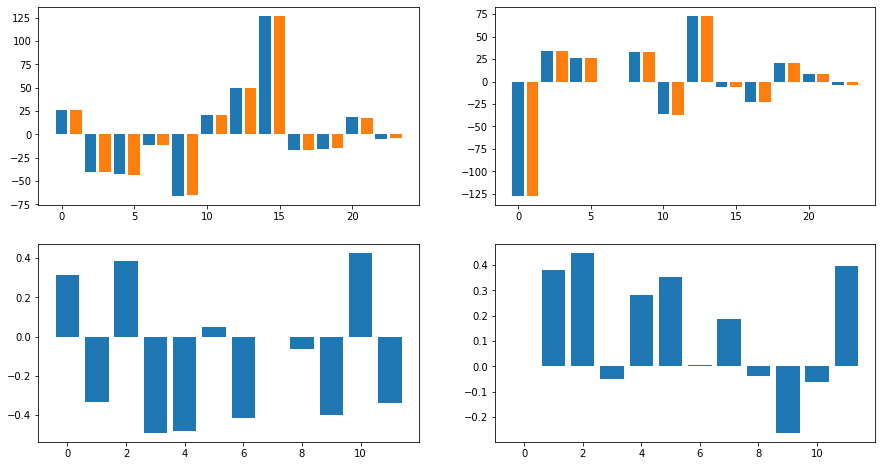

In [ ]:
#@title Solution

import numpy as np

keys = ['weights_in', 'weights_out']
fig, ax = plt.subplots(ncols=2, nrows=len(keys), figsize=(15, 8))
for i, key in enumerate(keys):
    data_original = 127*spec[key].flatten()/np.max(np.abs(spec[key].flatten()))
    data_quantized = quant_spec[key].flatten()
    ax[0][i].bar(range(12*2)[::2], data_original);
    ax[0][i].bar(range(12*2)[1::2], data_quantized);
    ax[1][i].bar(range(12), data_original-data_quantized);

In [ ]:
# create Xylo configuration from quantized sepecification
xylo_conf, is_valid, message = xylo.config_from_specification(**quant_spec)
print('Valid config: ', is_valid)

# create a XyloSim model
# this model simulates the Xylo chip
# the model can only process one input sample at a time since the chip works 
# in streaming mode
snn_xylo = XyloSim.from_config(xylo_conf, dt=dt)


def get_acc_xylo(dataloader, model):
    metric_xylo = torchmetrics.Accuracy()
    batch_acc = []
    for data, labels in iter(dataloader):
        labels_over_time, vmem_target = targets_over_time(labels, 
                                                          readout_floor, 
                                                          readout_target)
        for i in range(batch_size):
          model.reset_state()
          _, _, rec = model(data[i].numpy().astype(int), record=True)
          vmem_out = torch.from_numpy(rec['Vmem_out'])
          predictions = vmem_out[t_second_pulse:, :].argmax(1)
          acc = metric_xylo(predictions, labels_over_time[i])
          batch_acc.append(acc.item())

    return sum(batch_acc) / len(batch_acc)

Valid config:  True


In [ ]:
#@title Exercise: Evaluate XyloSim model

# TODO: evaluate test accuracy of the XyloSim model and compare
# to the rockpool model
# Hint: use get_acc_xylo() and get_acc()
# print('acc rockpool model', ...)
# print('acc XyloSim model', ...)

# TODO: insert one sample into the XyloSim model and 
# visualize the membrane potential of the readout neurons
# Hint: use the same figure and data samples as for the rockpool model


# TODO: create a XyloSim model with a lower threshold of the
# readout neurons and show that their spikining classifies the
# input correctly
# Hint: change the threshold in quant_spec and create a new XyloSim model

acc rockpool model 0.9479200005531311
acc XyloSim model 0.9355200010538102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  from ipykernel import kernelapp as app


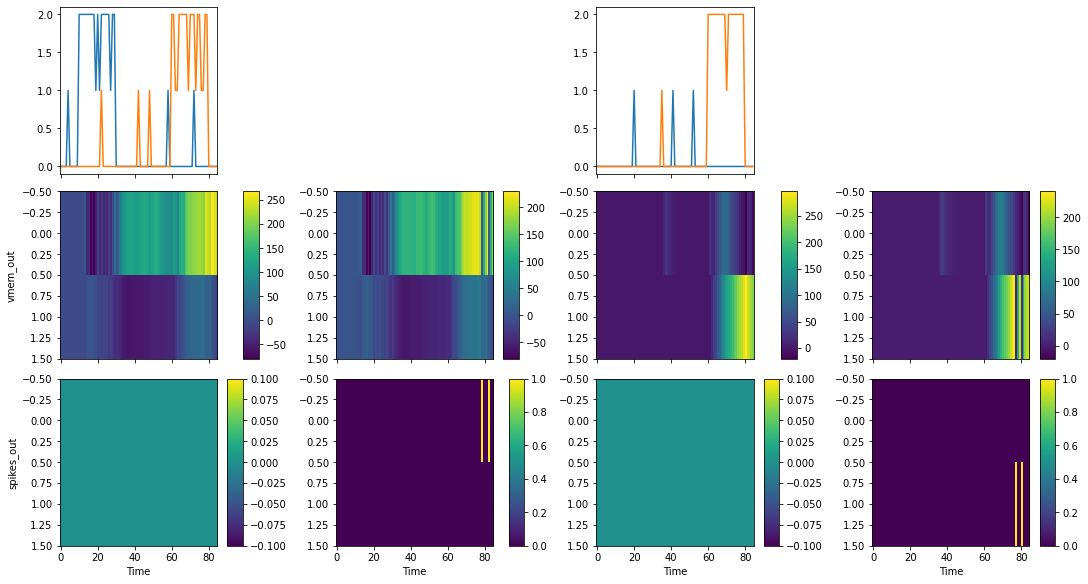

In [ ]:
#@title Solution Evaluate XyloSim model

# TODO: evaluate test accuracy of the XyloSim model and compare
# to the rockpool model
# Hint: use get_acc_xylo() and get_acc()
print('acc rockpool model', get_acc(test_loader, snn))
print('acc XyloSim model', get_acc_xylo(test_loader, snn_xylo))

# TODO: insert one sample into the XyloSim model and 
# visualize the membrane potential of the readout neurons

# pick the first signals in the batch corresponding to target values 0 and 1
t0, t1 = 0, 1
batch_idx_c0 = torch.range(0, batch_size-1, dtype=int)[labels_test[:, 0] == t0][0].item()
batch_idx_c1 = torch.range(0, batch_size-1, dtype=int)[labels_test[:, 0] == t1][0].item()

snn_xylo.reset_state()
out_xylo_c0, _, rec_xylo_c0 = snn_xylo(data_test[batch_idx_c0].numpy().astype(int), record=True)
vmem_out_xylo_c0 = torch.from_numpy(rec_xylo_c0['Vmem_out'])
snn_xylo.reset_state()
out_xylo_c1, _, rec_xylo_c1 = snn_xylo(data_test[batch_idx_c1].numpy().astype(int), record=True)
vmem_out_xylo_c1 = torch.from_numpy(rec_xylo_c1['Vmem_out'])


# visualize activity in layers
fig, ax = plt.subplots(3, 4, figsize=(15, 8), constrained_layout=True, 
                       sharex=True)

# plot stimuli
ax[0][0].plot(data_test[batch_idx_c0])
ax[0][1].axis('off')
ax[0][2].plot(data_test[batch_idx_c1])
ax[0][3].axis('off')
    
ax[1][0].set_ylabel('vmem_out')
img = ax[1][0].imshow(vmem_out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][0])
img = ax[1][2].imshow(vmem_out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][2])

ax[2][0].set_ylabel('spikes_out')
img = ax[2][0].imshow(out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][0]) 
img = ax[2][2].imshow(out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][2]) 

for i in range(4):  
  ax[2][i].set_xlabel("Time")


# TODO: create a XyloSim model with a lower threshold of the
# readout neurons and show that their spikining classifies the
# input correctly
# Hint: change the threshold in quant_spec and create a new XyloSim model
quant_spec_low_th = quant_spec.copy()
quant_spec_low_th['threshold_out'] = np.array([250, 250])
xylo_conf, is_valid, message = xylo.config_from_specification(**quant_spec_low_th)
snn_xylo_low_th = XyloSim.from_config(xylo_conf, dt=dt)

snn_xylo_low_th.reset_state()
out_xylo_c0, _, rec_xylo_c0 = snn_xylo_low_th(data_test[batch_idx_c0].numpy().astype(int), record=True)
vmem_out_xylo_c0 = torch.from_numpy(rec_xylo_c0['Vmem_out'])
snn_xylo_low_th.reset_state()
out_xylo_c1, _, rec_xylo_c1 = snn_xylo_low_th(data_test[batch_idx_c1].numpy().astype(int), record=True)
vmem_out_xylo_c1 = torch.from_numpy(rec_xylo_c1['Vmem_out'])

img = ax[1][1].imshow(vmem_out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][1])
img = ax[1][3].imshow(vmem_out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[1][3])

img = ax[2][1].imshow(out_xylo_c0.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][1]) 
img = ax[2][3].imshow(out_xylo_c1.T, aspect='auto', 
                      interpolation='none')
fig.colorbar(img, ax=ax[2][3])

plt.show()